# Inverse Kinematics with Neural Networks
## AI-Based Robot Control

### The AI Approach

Instead of using mathematical equations, we can train a neural network to learn the inverse kinematics mapping from examples. The network learns patterns from input-output pairs without explicit mathematical formulas.

**Key Differences from Mathematical Approach:**
- **Black box**: We don't know exactly how decisions are made
- **Pattern learning**: Network learns from examples, not equations  
- **Approximate**: Predictions may have errors but can generalize
- **Data-driven**: Performance depends on training data quality


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

2025-06-02 13:39:40.328812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Robot Arm Setup

In [2]:
class RobotArmAI:
    """Robot arm class for AI-based inverse kinematics"""
    
    def __init__(self, L1=120, L2=100):
        self.L1 = L1
        self.L2 = L2
        self.max_reach = L1 + L2
        self.min_reach = abs(L1 - L2)
        
        # Neural network components
        self.model = None
        self.scaler_input = StandardScaler()
        self.scaler_output = StandardScaler()
        self.is_trained = False
        
        print(f"AI Robot Arm Setup:")
        print(f"  L1 = {L1}, L2 = {L2}")
        print(f"  Reach: {self.min_reach} to {self.max_reach}")
        print(f"  Neural network: Not trained")
    
    def forward_kinematics(self, theta1, theta2):
        """Calculate end position from joint angles"""
        elbow_x = self.L1 * np.cos(theta1)
        elbow_y = self.L1 * np.sin(theta1)
        end_x = elbow_x + self.L2 * np.cos(theta1 + theta2)
        end_y = elbow_y + self.L2 * np.sin(theta1 + theta2)
        return end_x, end_y, elbow_x, elbow_y
    
    def generate_training_data(self, num_samples=5000):
        """Generate training data using forward kinematics"""
        print(f"Generating {num_samples} training examples...")
        
        X = []  # Input: [x, y] positions
        y = []  # Output: [theta1, theta2] angles
        
        for _ in range(num_samples):
            # Random joint angles
            theta1 = np.random.uniform(-np.pi, np.pi)
            theta2 = np.random.uniform(-np.pi, np.pi)
            
            # Calculate end position
            end_x, end_y, _, _ = self.forward_kinematics(theta1, theta2)
            
            # Only keep reachable positions
            distance = np.sqrt(end_x**2 + end_y**2)
            if self.min_reach <= distance <= self.max_reach:
                X.append([end_x, end_y])
                y.append([theta1, theta2])
        
        X = np.array(X)
        y = np.array(y)
        
        print(f"Generated {len(X)} valid training examples")
        return X, y
    
    def build_neural_network(self):
        """Create neural network architecture"""
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(2,), name='hidden1'),
            keras.layers.Dense(32, activation='relu', name='hidden2'),
            keras.layers.Dense(16, activation='relu', name='hidden3'),
            keras.layers.Dense(2, activation='linear', name='output')  # [theta1, theta2]
        ])
        
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train_network(self, num_samples=5000, epochs=100, verbose=True):
        """Train the neural network"""
        
        # Generate training data
        X, y = self.generate_training_data(num_samples)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Normalize data
        X_train_scaled = self.scaler_input.fit_transform(X_train)
        X_test_scaled = self.scaler_input.transform(X_test)
        y_train_scaled = self.scaler_output.fit_transform(y_train)
        y_test_scaled = self.scaler_output.transform(y_test)
        
        # Build and train model
        self.model = self.build_neural_network()
        
        if verbose:
            print(f"\nTraining neural network...")
            print(f"Architecture: Input(2) -> Hidden(64) -> Hidden(32) -> Hidden(16) -> Output(2)")
            print(f"Training samples: {len(X_train)}")
            print(f"Test samples: {len(X_test)}")
        
        # Train with early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        history = self.model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_test_scaled, y_test_scaled),
            epochs=epochs,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0 if not verbose else 1
        )
        
        # Evaluate
        test_loss, test_mae = self.model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
        
        self.is_trained = True
        
        if verbose:
            print(f"\nTraining completed!")
            print(f"Test Loss (MSE): {test_loss:.6f}")
            print(f"Test MAE: {test_mae:.6f}")
        
        return history, X_test, y_test
    
    def predict_ik(self, target_x, target_y):
        """Predict joint angles using trained neural network"""
        if not self.is_trained:
            raise ValueError("Neural network must be trained first!")
        
        # Prepare input
        X_input = np.array([[target_x, target_y]])
        X_scaled = self.scaler_input.transform(X_input)
        
        # Predict
        y_pred_scaled = self.model.predict(X_scaled, verbose=0)
        y_pred = self.scaler_output.inverse_transform(y_pred_scaled)
        
        theta1, theta2 = y_pred[0]
        return theta1, theta2
    
    def plot_prediction(self, target_x, target_y, show_training_data=False):
        """Visualize AI prediction"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Draw workspace
        max_circle = Circle((0, 0), self.max_reach, fill=False, color='lightgray', linestyle='--')
        min_circle = Circle((0, 0), self.min_reach, fill=False, color='lightcoral', linestyle=':')
        ax.add_patch(max_circle)
        ax.add_patch(min_circle)
        
        # Show some training data points
        if show_training_data and self.is_trained:
            X_sample, _ = self.generate_training_data(200)
            ax.scatter(X_sample[:, 0], X_sample[:, 1], c='orange', alpha=0.3, s=10, label='Training Data')
        
        try:
            # Get AI prediction
            theta1, theta2 = self.predict_ik(target_x, target_y)
            end_x, end_y, elbow_x, elbow_y = self.forward_kinematics(theta1, theta2)
            
            # Draw predicted arm configuration
            ax.plot([0, elbow_x], [0, elbow_y], 'b-', linewidth=8, alpha=0.7, label='Upper Arm')
            ax.plot([elbow_x, end_x], [elbow_y, end_y], 'r-', linewidth=6, alpha=0.7, label='Forearm')
            ax.plot(0, 0, 'ko', markersize=10, label='Base')
            ax.plot(elbow_x, elbow_y, 'bo', markersize=8)
            ax.plot(end_x, end_y, 'ro', markersize=8, label='AI Prediction')
            
            # Calculate error
            error = np.sqrt((end_x - target_x)**2 + (end_y - target_y)**2)
            
            # Add prediction info
            ax.text(0.02, 0.98, f'AI Prediction:\nθ₁ = {np.degrees(theta1):.1f}°\nθ₂ = {np.degrees(theta2):.1f}°\nError = {error:.2f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
        except ValueError as e:
            ax.text(0.5, 0.5, str(e), transform=ax.transAxes, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        
        # Mark target
        ax.plot(target_x, target_y, 'g*', markersize=15, label='Target')
        ax.plot([target_x-10, target_x+10], [target_y, target_y], 'g-', linewidth=2)
        ax.plot([target_x, target_x], [target_y-10, target_y+10], 'g-', linewidth=2)
        
        ax.set_xlim(-self.max_reach*1.1, self.max_reach*1.1)
        ax.set_ylim(-self.max_reach*1.1, self.max_reach*1.1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_title(f'Neural Network IK Prediction for ({target_x}, {target_y})', fontweight='bold')
        plt.tight_layout()
        plt.show()

# Create AI robot
robot_ai = RobotArmAI(L1=120, L2=100)

AI Robot Arm Setup:
  L1 = 120, L2 = 100
  Reach: 20 to 220
  Neural network: Not trained


### Training the Neural Network

In [3]:
# Train the neural network
history, X_test, y_test = robot_ai.train_network(num_samples=5000, epochs=50, verbose=True)

Generating 5000 training examples...
Generated 5000 valid training examples

Training neural network...
Architecture: Input(2) -> Hidden(64) -> Hidden(32) -> Hidden(16) -> Output(2)
Training samples: 4000
Test samples: 1000
Epoch 1/50


2025-06-02 13:39:49.314778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 13:39:49.315691: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


125/125 [==============================] - 1s 8ms/step - loss: 0.8368 - mae: 0.7451 - val_loss: 0.7708 - val_mae: 0.7086
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.8035 - mae: 0.7167 - val_loss: 0.7667 - val_mae: 0.7105
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.7980 - mae: 0.7166 - val_loss: 0.7720 - val_mae: 0.7093
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 0.7957 - mae: 0.7158 - val_loss: 0.7753 - val_mae: 0.7095
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.7928 - mae: 0.7134 - val_loss: 0.7609 - val_mae: 0.7063
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.7912 - mae: 0.7131 - val_loss: 0.7573 - val_mae: 0.7074
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 0.7887 - mae: 0.7130 - val_loss: 0.7582 - val_mae: 0.7038
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.7885 - mae:

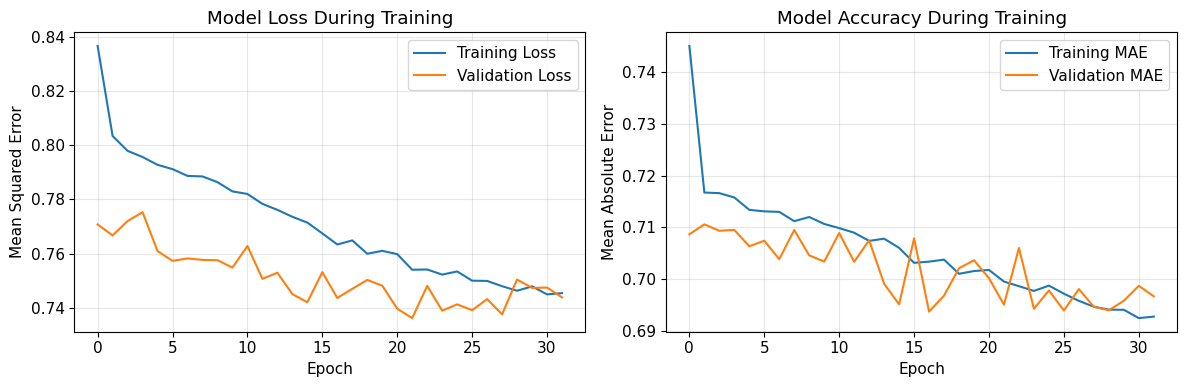

In [4]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss During Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves  
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model Accuracy During Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Neural Network Architecture

In [5]:
# Display model architecture
print("Neural Network Architecture:")
print("=" * 30)
robot_ai.model.summary()

Neural Network Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 64)                192       
                                                                 
 hidden2 (Dense)             (None, 32)                2080      
                                                                 
 hidden3 (Dense)             (None, 16)                528       
                                                                 
 output (Dense)              (None, 2)                 34        
                                                                 
Total params: 2,834
Trainable params: 2,834
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Visualize network architecture
keras.utils.plot_model(robot_ai.model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Testing AI Predictions

In [7]:
# Test the trained network on various targets
test_targets = [
    (100, 80, "Easy case"),
    (150, -50, "Negative Y"),
    (-120, 60, "Negative X"), 
    (180, 120, "Near boundary"),
    (50, 30, "Close to base")
]

print("Testing AI Predictions:")
print("-" * 25)

for target_x, target_y, description in test_targets:
    print(f"\nTarget: ({target_x}, {target_y}) - {description}")
    
    try:
        theta1, theta2 = robot_ai.predict_ik(target_x, target_y)
        
        # Verify with forward kinematics
        end_x, end_y, _, _ = robot_ai.forward_kinematics(theta1, theta2)
        error = np.sqrt((end_x - target_x)**2 + (end_y - target_y)**2)
        
        print(f"  AI Prediction: θ₁={np.degrees(theta1):.1f}°, θ₂={np.degrees(theta2):.1f}°")
        print(f"  Actual end position: ({end_x:.1f}, {end_y:.1f})")
        print(f"  Error: {error:.2f} pixels")
        
    except Exception as e:
        print(f"  Error: {e}")

Testing AI Predictions:
-------------------------

Target: (100, 80) - Easy case
  AI Prediction: θ₁=25.3°, θ₂=7.4°
  Actual end position: (192.6, 105.3)
  Error: 96.04 pixels

Target: (150, -50) - Negative Y
  AI Prediction: θ₁=-21.9°, θ₂=2.9°
  Actual end position: (206.0, -77.1)
  Error: 62.18 pixels

Target: (-120, 60) - Negative X
  AI Prediction: θ₁=-9.2°, θ₂=-1.5°
  Actual end position: (216.7, -37.8)
  Error: 350.63 pixels

Target: (180, 120) - Near boundary
  AI Prediction: θ₁=28.3°, θ₂=2.6°
  Actual end position: (191.4, 108.3)
  Error: 16.39 pixels

Target: (50, 30) - Close to base
  AI Prediction: θ₁=16.6°, θ₂=14.4°
  Actual end position: (200.7, 85.8)
  Error: 160.71 pixels


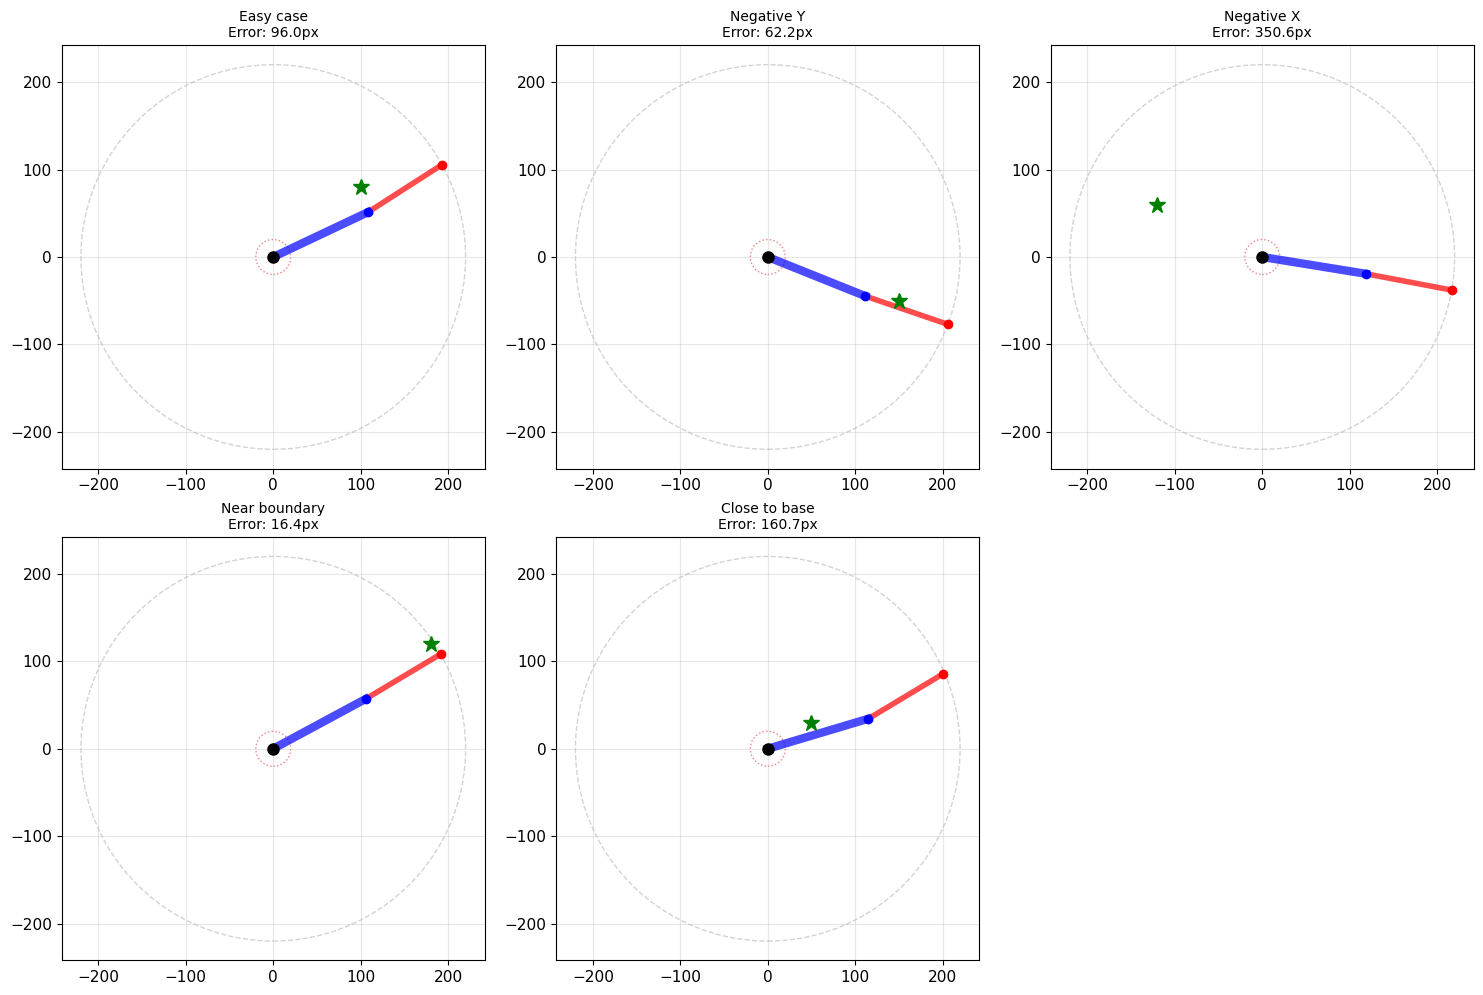

In [8]:
# Visualize a few predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (target_x, target_y, description) in enumerate(test_targets):
    if i >= len(axes):
        break
    
    ax = axes[i]
    
    # Draw workspace
    max_circle = Circle((0, 0), robot_ai.max_reach, fill=False, color='lightgray', linestyle='--')
    min_circle = Circle((0, 0), robot_ai.min_reach, fill=False, color='lightcoral', linestyle=':')
    ax.add_patch(max_circle)
    ax.add_patch(min_circle)
    
    try:
        # Get prediction
        theta1, theta2 = robot_ai.predict_ik(target_x, target_y)
        end_x, end_y, elbow_x, elbow_y = robot_ai.forward_kinematics(theta1, theta2)
        error = np.sqrt((end_x - target_x)**2 + (end_y - target_y)**2)
        
        # Draw arm
        ax.plot([0, elbow_x], [0, elbow_y], 'b-', linewidth=6, alpha=0.7)
        ax.plot([elbow_x, end_x], [elbow_y, end_y], 'r-', linewidth=4, alpha=0.7)
        ax.plot(0, 0, 'ko', markersize=8)
        ax.plot(elbow_x, elbow_y, 'bo', markersize=6)
        ax.plot(end_x, end_y, 'ro', markersize=6)
        
        title = f"{description}\nError: {error:.1f}px"
        
    except:
        title = f"{description}\nPrediction failed"
    
    # Mark target
    ax.plot(target_x, target_y, 'g*', markersize=12)
    
    ax.set_xlim(-robot_ai.max_reach*1.1, robot_ai.max_reach*1.1)
    ax.set_ylim(-robot_ai.max_reach*1.1, robot_ai.max_reach*1.1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide last subplot if not used
if len(test_targets) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Comparing AI vs Mathematical Approach

In [9]:
# Compare AI predictions with mathematical solutions
from scipy.optimize import fsolve

def mathematical_ik(target_x, target_y, L1, L2):
    """Mathematical inverse kinematics solution"""
    distance = np.sqrt(target_x**2 + target_y**2)
    
    # Check reachability
    if distance > L1 + L2 or distance < abs(L1 - L2):
        return None, None
    
    # Calculate theta2
    cos_theta2 = (target_x**2 + target_y**2 - L1**2 - L2**2) / (2 * L1 * L2)
    cos_theta2 = np.clip(cos_theta2, -1, 1)
    theta2 = -np.arccos(cos_theta2)  # Elbow down
    
    # Calculate theta1
    theta1 = np.arctan2(target_y, target_x) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))
    
    return theta1, theta2

# Compare on test cases
comparison_targets = [(120, 80), (150, -60), (-100, 100), (180, 50)]

print("AI vs Mathematical Comparison:")
print("=" * 35)
print(f"{'Target':<12} {'AI θ₁':<8} {'Math θ₁':<8} {'AI θ₂':<8} {'Math θ₂':<8} {'AI Error':<10} {'Math Error':<10}")
print("-" * 80)

for target_x, target_y in comparison_targets:
    # AI prediction
    try:
        ai_theta1, ai_theta2 = robot_ai.predict_ik(target_x, target_y)
        ai_end_x, ai_end_y, _, _ = robot_ai.forward_kinematics(ai_theta1, ai_theta2)
        ai_error = np.sqrt((ai_end_x - target_x)**2 + (ai_end_y - target_y)**2)
    except:
        ai_theta1 = ai_theta2 = ai_error = float('nan')
    
    # Mathematical solution
    math_theta1, math_theta2 = mathematical_ik(target_x, target_y, robot_ai.L1, robot_ai.L2)
    if math_theta1 is not None:
        math_end_x, math_end_y, _, _ = robot_ai.forward_kinematics(math_theta1, math_theta2)
        math_error = np.sqrt((math_end_x - target_x)**2 + (math_end_y - target_y)**2)
    else:
        math_error = float('nan')
    
    print(f"({target_x:3},{target_y:3})   {np.degrees(ai_theta1):6.1f}°  {np.degrees(math_theta1):6.1f}°  {np.degrees(ai_theta2):6.1f}°  {np.degrees(math_theta2):6.1f}°  {ai_error:8.3f}   {math_error:8.3f}")


AI vs Mathematical Comparison:
Target       AI θ₁    Math θ₁  AI θ₂    Math θ₂  AI Error   Math Error
--------------------------------------------------------------------------------
(120, 80)     23.1°    77.0°     6.6°   -98.6°    79.064      0.000
(150,-60)    -25.6°    16.3°     2.5°   -85.9°    59.035      0.000
(-100,100)     46.1°   179.0°     1.7°  -100.6°   257.629      0.000
(180, 50)      8.3°    44.3°     6.1°   -64.1°    36.342      0.000


### Error Analysis

Analyzing Neural Network Performance...
----------------------------------------
Generating 1000 training examples...
Generated 1000 valid training examples
Test samples: 1000
Successful predictions: 1000 (100.0%)
Mean error: 132.010 pixels
Median error: 101.748 pixels
Max error: 439.485 pixels
Std error: 110.592 pixels


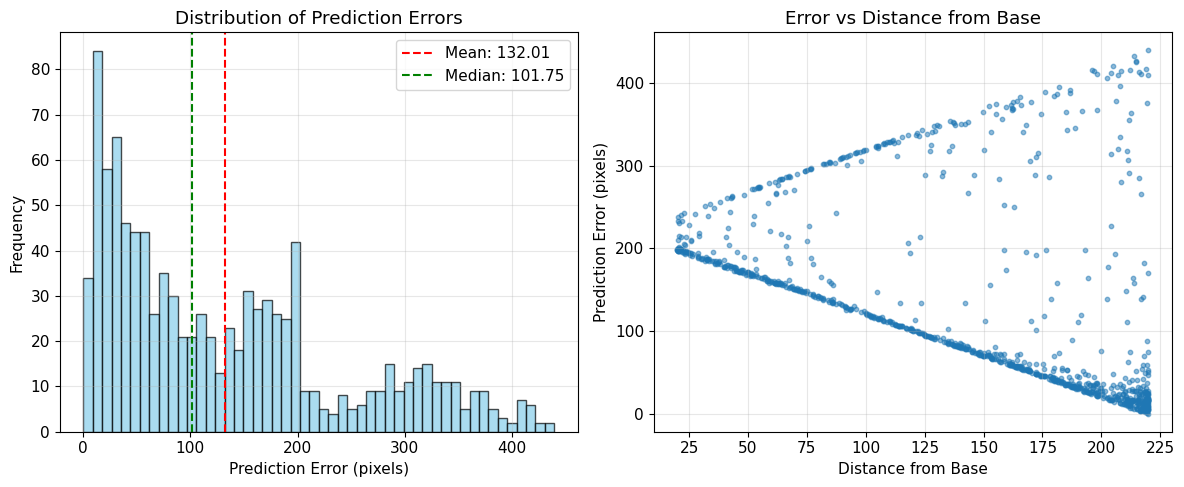

In [10]:
# Comprehensive error analysis
def analyze_network_performance(robot, num_test_samples=1000):
    """Analyze neural network performance across workspace"""
    
    print("Analyzing Neural Network Performance...")
    print("-" * 40)
    
    # Generate test data
    X_test, y_true = robot.generate_training_data(num_test_samples)
    
    errors = []
    predictions = []
    
    for i, (target_x, target_y) in enumerate(X_test):
        try:
            # AI prediction
            pred_theta1, pred_theta2 = robot.predict_ik(target_x, target_y)
            pred_end_x, pred_end_y, _, _ = robot.forward_kinematics(pred_theta1, pred_theta2)
            
            # Calculate error
            error = np.sqrt((pred_end_x - target_x)**2 + (pred_end_y - target_y)**2)
            errors.append(error)
            predictions.append([pred_theta1, pred_theta2])
            
        except:
            errors.append(float('inf'))
            predictions.append([float('nan'), float('nan')])
    
    errors = np.array(errors)
    finite_errors = errors[np.isfinite(errors)]
    
    print(f"Test samples: {len(X_test)}")
    print(f"Successful predictions: {len(finite_errors)} ({len(finite_errors)/len(X_test)*100:.1f}%)")
    print(f"Mean error: {np.mean(finite_errors):.3f} pixels")
    print(f"Median error: {np.median(finite_errors):.3f} pixels")
    print(f"Max error: {np.max(finite_errors):.3f} pixels")
    print(f"Std error: {np.std(finite_errors):.3f} pixels")
    
    # Plot error distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Error histogram
    ax1.hist(finite_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(finite_errors), color='red', linestyle='--', label=f'Mean: {np.mean(finite_errors):.2f}')
    ax1.axvline(np.median(finite_errors), color='green', linestyle='--', label=f'Median: {np.median(finite_errors):.2f}')
    ax1.set_xlabel('Prediction Error (pixels)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error vs distance from center
    distances = np.sqrt(X_test[:, 0]**2 + X_test[:, 1]**2)
    valid_idx = np.isfinite(errors)
    
    ax2.scatter(distances[valid_idx], errors[valid_idx], alpha=0.5, s=10)
    ax2.set_xlabel('Distance from Base')
    ax2.set_ylabel('Prediction Error (pixels)')
    ax2.set_title('Error vs Distance from Base')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return finite_errors

# Run performance analysis
errors = analyze_network_performance(robot_ai, 1000)

### Interactive Prediction Demo

Interactive AI Demo
Try different target positions!
------------------------------

Testing: Symmetric position at (100, 100)
Generating 200 training examples...
Generated 200 valid training examples


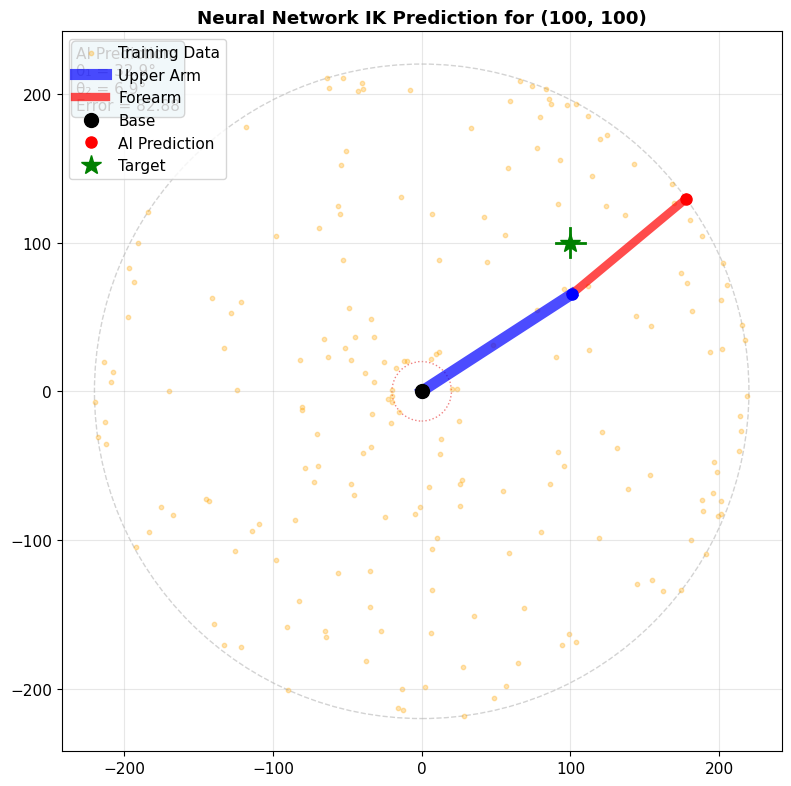


Testing: Far reach at (200, 50)
Generating 200 training examples...
Generated 200 valid training examples


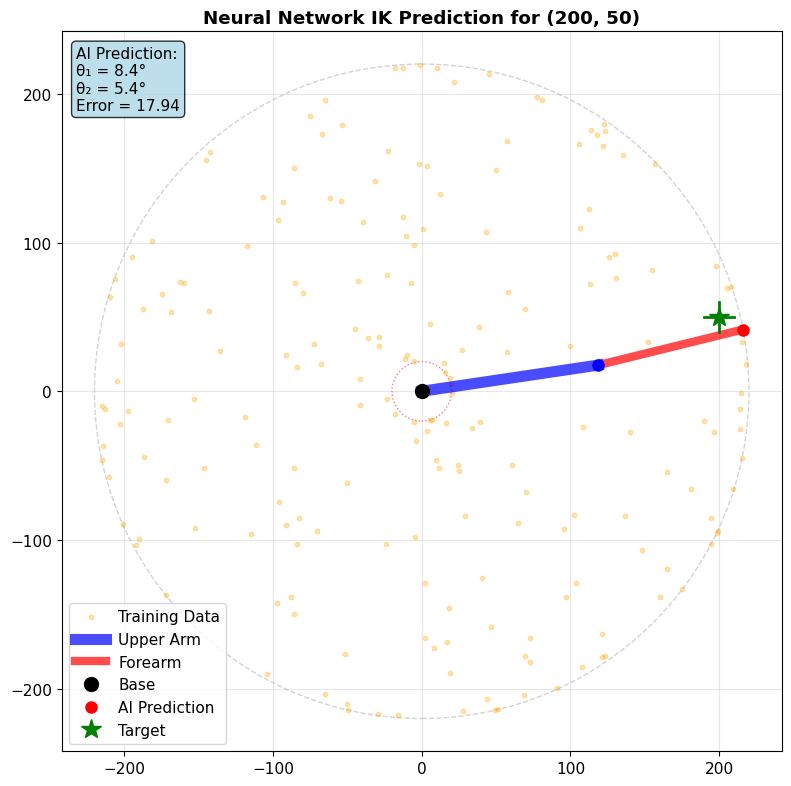


Testing: Left side at (-150, 80)
Generating 200 training examples...
Generated 200 valid training examples


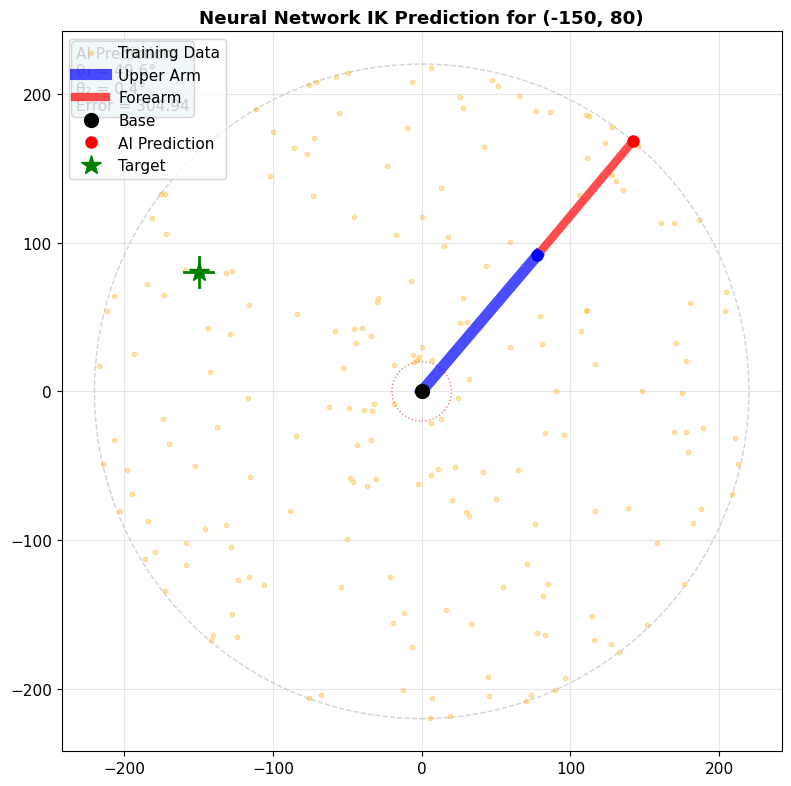


Testing: High up at (50, 150)
Generating 200 training examples...
Generated 200 valid training examples


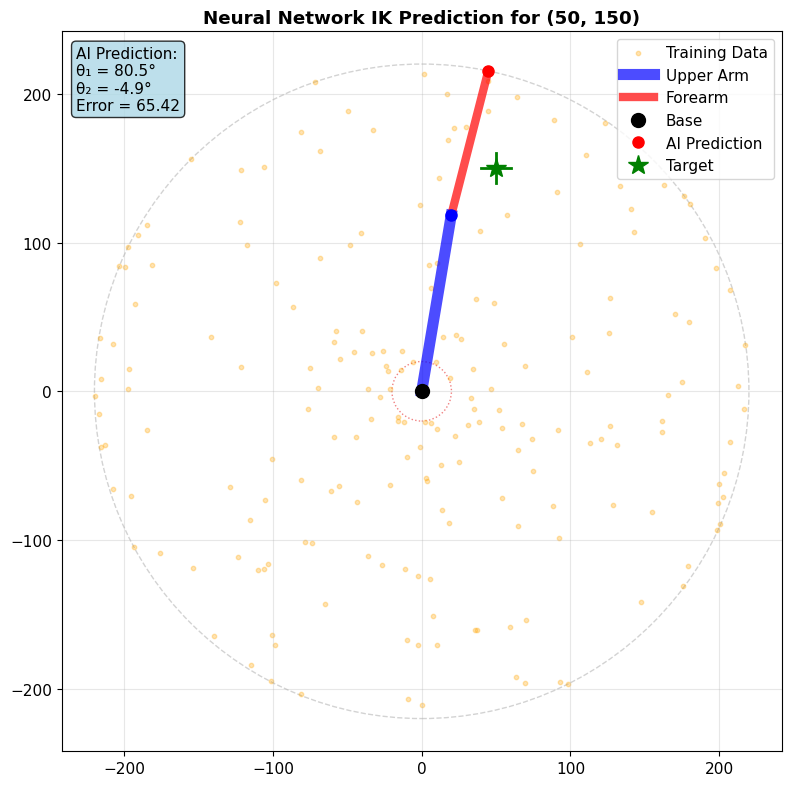


Testing: Straight up at (0, 100)
Generating 200 training examples...
Generated 200 valid training examples


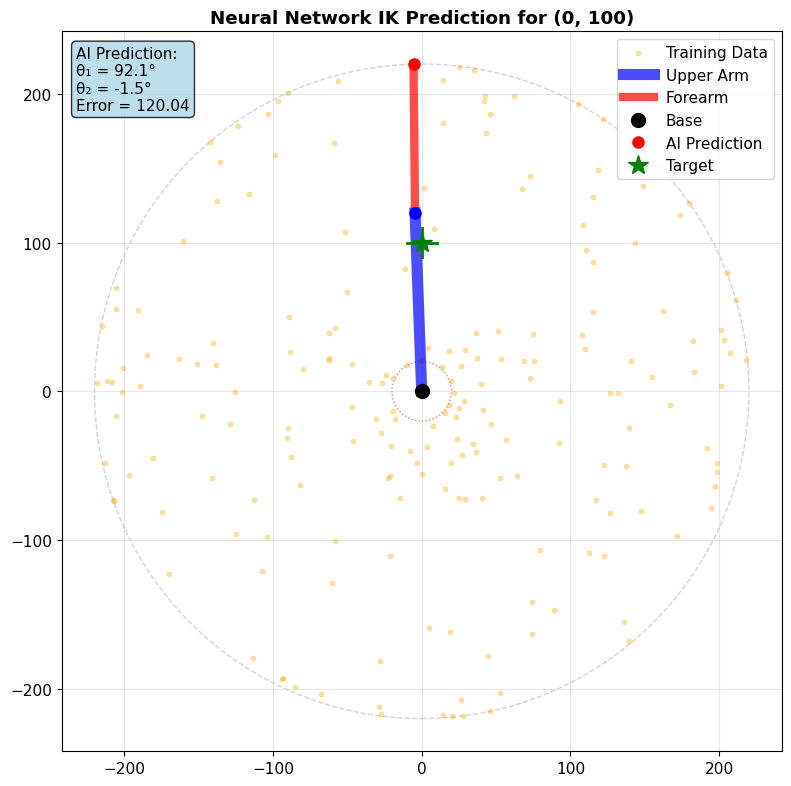

In [11]:
# Interactive demo function
def interactive_demo():
    """Interactive demonstration of AI predictions"""
    
    print("Interactive AI Demo")
    print("Try different target positions!")
    print("-" * 30)
    
    # Some interesting test cases
    demo_targets = [
        (100, 100, "Symmetric position"),
        (200, 50, "Far reach"),
        (-150, 80, "Left side"),
        (50, 150, "High up"),
        (0, 100, "Straight up")
    ]
    
    for target_x, target_y, description in demo_targets:
        print(f"\nTesting: {description} at ({target_x}, {target_y})")
        robot_ai.plot_prediction(target_x, target_y, show_training_data=True)

# Run interactive demo
interactive_demo()

### Summary: AI vs Mathematical Approaches

**Neural Network Advantages:**
- Can handle complex, non-analytical systems
- Learns from data without explicit equations
- Can potentially handle noise and uncertainties
- Generalizes to similar problems

**Neural Network Disadvantages:**
- Black box - no interpretability
- Requires training data and time
- Approximate solutions with potential errors
- Performance depends on training quality

**Mathematical Advantages:**
- Exact solutions (within numerical precision)
- Fast computation once derived
- Fully interpretable and predictable
- No training required

**Mathematical Disadvantages:**
- Requires analytical solutions to exist
- May not handle complex constraints easily
- Limited to well-defined mathematical systems

### Key Takeaways

1. **Data Quality Matters**: Neural network performance depends heavily on training data
2. **Trade-offs**: AI offers flexibility but sacrifices exactness and interpretability  
3. **Complementary Approaches**: Both methods have their place in robotics
4. **Error Analysis**: Always validate AI predictions, especially for safety-critical applications
5. **Computational Costs**: Training takes time, but inference can be fast

**When to Use Each Approach:**
- **Mathematical**: When exact solutions exist and are derivable
- **AI**: When systems are too complex for analytical solutions or when learning from demonstration data